# SPIN PERIOD AND FOLDED PULSE OF VELA X-1

##### In this example we will use the function period_sliding_window to obtain both the NS period of the source and observe its evolution and observe the pulse shape. For it we will use a 0.5 s light curve from a XMM-Newton observation.

In [1]:
import pytest
import numpy as np
import os
import sys

sys.path.append('/Users/graci/Desktop/git/xraybinaryorbit/xraybinaryorbit')
from xraybinaryorbit import *

/Users/graci/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (




HELLO, nice to see you! :)

PLEASE READ THIS, IT'S VERY IMPORTANT:

These are the units that must be used within this package:

- Rstar: Solar radius
- Mstar: Solar masses
- Inclination: Sexagesimal degrees
- Periapsis: Sexagesimal degrees
- Semimajor: Stellar radius
- Periods: Days (Periods in the case of the period_sliding_window function will support any units)
- Iphase: Radians

A list of the functions contained in this package will be displayed by runing the function list_functions().

As these functions use a lot of parameters, which can sometimes be difficult to handle, we have implemented a user-friendly method for parameter input:
A form will be displayed, and the parameters will be saved in the directory for further interactions. These saved parameters will be used if new parameters are not provided.
For the function to work, the submit button must be pressed.

Please, take into account that fits in general will take A LOT of time to complete.

If you need help, contact gra

Text(0, 0.5, 'Rate')

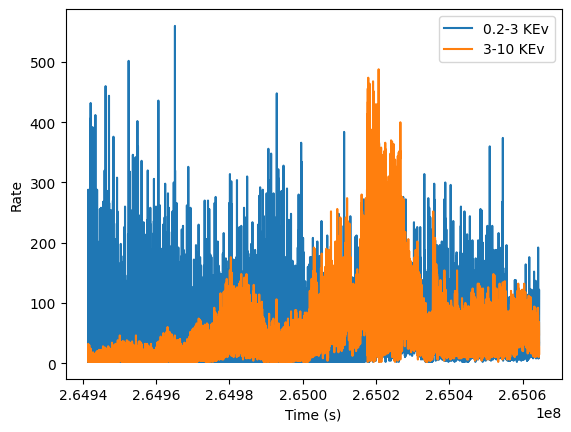

In [2]:
high = pd.read_csv("vela_high.txt",  comment="!", delim_whitespace=True, skiprows=1, header=None)
low = pd.read_csv("vela_low.txt",  comment="!", delim_whitespace=True, skiprows=1, header=None)

#Indicate the time rate and errors (t,c and sc) for high (h) and low(l) energy light curves respectively. Filter de data: Nor values with neg values or equal to 0 allowed
high=high[high[1]>0].reset_index(drop=True)
th=high[2]
ch=high[0]
sch=high[1]

low=low[low[1]>0].reset_index(drop=True)
tl=low[2]
cl=low[0]
scl=low[1]

#Visualize
plt.plot(tl,cl, label="0.2-3 KEv")
plt.plot(th,ch, label="3-10 KEv")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Rate")

In [3]:
resulth, pulsesh = period_sliding_window(th,ch,sch,50000,25000,min_period=260, max_period=310,folded_pulses=True, snr_pulse=0.02, nbin_pulse=None)
resultl, pulsesl = period_sliding_window(tl,cl,scl,50000,25000,min_period=260, max_period=310,folded_pulses=True, snr_pulse=0.02, nbin_pulse=None)

In [4]:
#The results must bbe filtered, as the program captures all peaks in the periodogram within each window:

fa=1e-10 #Determine the maximun false alarm probability allowed
min_snr= 3 #Determine the minimum signal to noise allowed for the periodogram peak.

filt_resulth = resulth[(resulth.Period>282) & (resulth.Period<285) & (resulth.False_alarm<fa) & (resulth.snr>=min_snr)]
filt_pulsesh = {i: pulsesh[i] for i in filt_resulth.index if i in pulsesh}

filt_resultl = resultl[(resultl.Period>282) & (resultl.Period<285) & (resultl.False_alarm<fa) & (resultl.snr>=min_snr)]
filt_pulsesl = {i: pulsesl[i] for i in filt_resultl.index if i in pulsesl}

In [5]:
#OBSERVE RESULT
#Rebin light curves for visualization purposes
high_reb = rebin_snr_(th,ch,sch,0.01)
low_reb = rebin_snr_(tl,cl,scl,0.02)


plt.figure(figsize=(10, 5))
plt.plot(high_reb[0],scale(high_reb[1],np.array(filt_resulth.Period)),"r" ,alpha=0.2) #Scale it for visualization purposes (scale_ function)
plt.plot(low_reb[0],scale(low_reb[1],np.array(filt_resulth.Period)),"g" ,alpha=0.2) #Scale it for visualization purposes (scale_ function)

for x, y, xerr, yerr in zip((filt_resulth.min_time+filt_resulth.max_time)/2,
                            filt_resulth.Period,
                            abs(filt_resulth.min_time-filt_resulth.max_time)/2,
                            filt_resulth.Period_Error):
    plt.gca().add_patch(plt.Rectangle((x-xerr/2, y-yerr/2), xerr, yerr, fill=False, edgecolor='blue', alpha=1))

plt.scatter((filt_resulth.min_time+filt_resulth.max_time)/2, filt_resulth.Period, 
            color='blue', marker='o', alpha=1, label='3-10 keV')


for x, y, xerr, yerr in zip((filt_resultl.min_time+filt_resultl.max_time)/2,
                            filt_resultl.Period,
                            abs(filt_resultl.min_time-filt_resultl.max_time)/2,
                            filt_resultl.Period_Error):
    plt.gca().add_patch(plt.Rectangle((x-xerr/2, y-yerr/2), xerr, yerr, fill=False, edgecolor='green', alpha=1))

plt.scatter((filt_resultl.min_time+filt_resultl.max_time)/2, filt_resultl.Period, 
            color='green', marker='o', alpha=0.4, label='0.2-3 keV')

plt.legend()
plt.xlim(min(th),max(th))
plt.xlabel("Time (s)", fontsize=20)
plt.ylabel("NS spin period (s)", fontsize=20)
plt.savefig("velax1_spin.png")

NameError: name 'rebin_snr_' is not defined

In [ ]:
# Number of pulses to plot
num_pulses = len(filt_pulsesh)

# Define number of rows and columns
n_cols = 4
n_rows = (num_pulses + n_cols - 1) // n_cols  # Ensure enough rows for all pulses

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4+1, n_rows * 3+1))

# Flatten axes in case of multiple rows
axes = axes.flatten()

# Loop over the filtered pulses and plot
for i, (idx, pulse_data) in enumerate(filt_pulsesh.items()):
    ax = axes[i]
    ph_pulse = pulse_data['ph_pulse']
    c_pulse = pulse_data['c_pulse']
    sc_pulse = pulse_data['sc_pulse']
    
    concatenated_c_pulse = np.concatenate([c_pulse[np.argmin(c_pulse):len(c_pulse)], c_pulse[0:np.argmin(c_pulse)]])
    concatenated_ph_pulse = np.concatenate([ph_pulse[np.argmin(c_pulse):len(c_pulse)], np.array(ph_pulse[0:np.argmin(c_pulse)]) + 1])
    concatenated_sc_pulse = np.concatenate([sc_pulse[np.argmin(c_pulse):len(c_pulse)], sc_pulse[0:np.argmin(c_pulse)]])
    
    # Plot pulse data
    ax.errorbar(concatenated_ph_pulse, concatenated_c_pulse, yerr=concatenated_sc_pulse, fmt=':', label=f'Pulse {i+1}',alpha=1)
    ax.errorbar(concatenated_ph_pulse, concatenated_c_pulse,  fmt='b')
    ax.set_xlabel('NS Spin Phase')
    ax.set_ylabel('Counts')
    ax.legend()


# Turn off empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.savefig("high_folded_pulses_velax1.png")

In [ ]:
# Number of pulses to plot
num_pulses = len(filt_pulsesl)

# Define number of rows and columns
n_cols = 4
n_rows = (num_pulses + n_cols - 1) // n_cols  # Ensure enough rows for all pulses

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4+1, n_rows * 3+1))

# Flatten axes in case of multiple rows
axes = axes.flatten()

# Loop over the filtered pulses and plot
for i, (idx, pulse_data) in enumerate(filt_pulsesl.items()):
    ax = axes[i]
    ph_pulse = pulse_data['ph_pulse']
    c_pulse = pulse_data['c_pulse']
    sc_pulse = pulse_data['sc_pulse']
    
    concatenated_c_pulse = np.concatenate([c_pulse[np.argmin(c_pulse):len(c_pulse)], c_pulse[0:np.argmin(c_pulse)]])
    concatenated_ph_pulse = np.concatenate([ph_pulse[np.argmin(c_pulse):len(c_pulse)], np.array(ph_pulse[0:np.argmin(c_pulse)]) + 1])
    concatenated_sc_pulse = np.concatenate([sc_pulse[np.argmin(c_pulse):len(c_pulse)], sc_pulse[0:np.argmin(c_pulse)]])
    
    # Plot pulse data
    ax.errorbar(concatenated_ph_pulse, concatenated_c_pulse, yerr=concatenated_sc_pulse, fmt=':', label=f'Pulse {i+1}',alpha=0.2)
    ax.errorbar(concatenated_ph_pulse, concatenated_c_pulse,  fmt='g')
    ax.set_xlabel('NS Spin Phase')
    ax.set_ylabel('Counts')
    ax.legend()


# Turn off empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.savefig("low_folded_pulses_velax1.png")